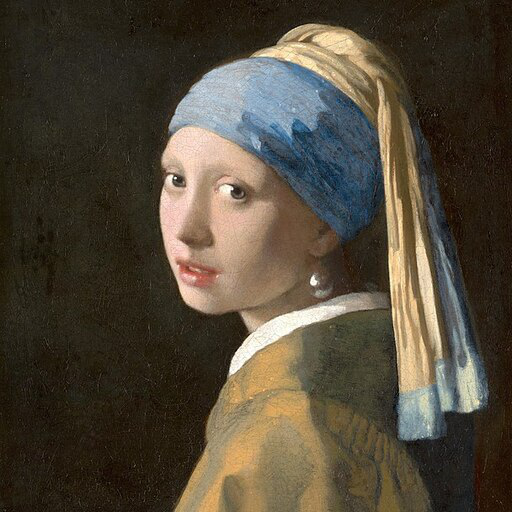

In [51]:
from diffusers.utils import load_image

image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

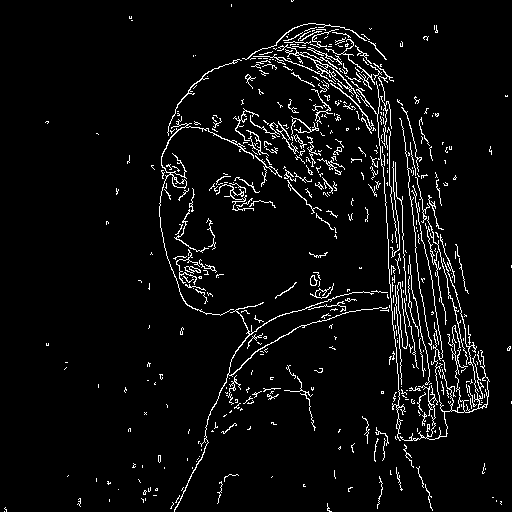

In [52]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

canny_image

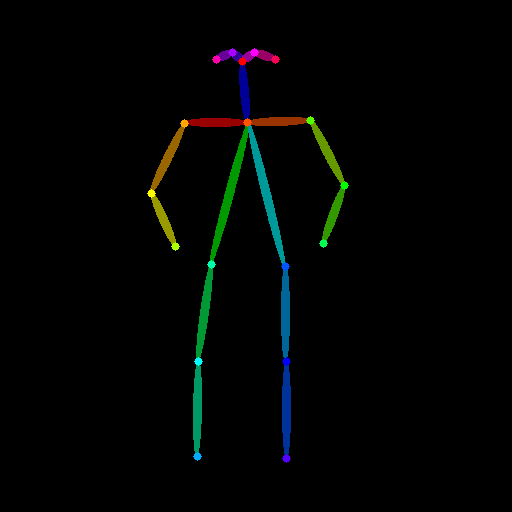

In [53]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

openpose_image = openpose(openpose_image)

openpose_image

In [58]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from pathlib import Path

model_id = "runwayml/stable-diffusion-v1-5"

controlnet = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16),
    # ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
]

pipe = StableDiffusionControlNetPipeline.from_pretrained(model_id, controlnet=controlnet, torch_dtype=torch.float16, safety_checker=None)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

pipe

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:12                                                                                   │
│                                                                                                  │
│    9 │   # ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torc    │
│   10 ]                                                                                           │
│   11                                                                                             │
│ ❱ 12 pipe = StableDiffusionControlNetPipeline.from_pretrained(model_id, controlnet=controlnet    │
│   13 pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)                 │
│   14                                                                                             │
│   15 pipe.enable_model_cpu_offload()                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:908 in             │
│ from_pretrained                                                                                  │
│                                                                                                  │
│    905 │   │   # 1. Download the checkpoints and configs                                         │
│    906 │   │   # use snapshot download here to get it working from from_pretrained               │
│    907 │   │   if not os.path.isdir(pretrained_model_name_or_path):                              │
│ ❱  908 │   │   │   cached_folder = cls.download(                                                 │
│    909 │   │   │   │   pretrained_model_name_or_path,                                            │
│    910 │   │   │   │   cache_dir=cache_dir,                                                      │
│    911 │   │   │   │   resume_download=resume_download,                                          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:1219 in download   │
│                                                                                                  │
│   1216 │   │                                                                                     │
│   1217 │   │   if not local_files_only:                                                          │
│   1218 │   │   │   try:                                                                          │
│ ❱ 1219 │   │   │   │   info = model_info(                                                        │
│   1220 │   │   │   │   │   pretrained_model_name,                                                │
│   1221 │   │   │   │   │   use_auth_token=use_auth_token,                                        │
│   1222 │   │   │   │   │   revision=revision,                                                    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:110 in _inner_fn    │
│                                                                                                  │
│   107 │   │   │   kwargs.items(),  # Kwargs values                                               │
│   108 │   │   ):                                                                                 │
│   109 │   │   │   if arg_name in ["repo_id", "from_id", "to_id"]:                                │
│ ❱ 110 │   │   │   │   validate_repo_id(arg_value)                                                │
│   111 │   │   │                                                                                  │
│   112 │   │   │   elif arg_name == "token" and arg_value is

In [55]:
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Sandra Oh", "Kim Kardashian", "rihanna", "mr potato head"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    [openpose_image],
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=30,
    generator=generator,
)

output

You have 1 ControlNets and you have passed 4 prompts. The conditionings will be fixed across the prompts.
100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7FC1B229BAF0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7FC1B229BDC0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7FC1B229A500>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7FC1B229BF10>], nsfw_content_detected=None)

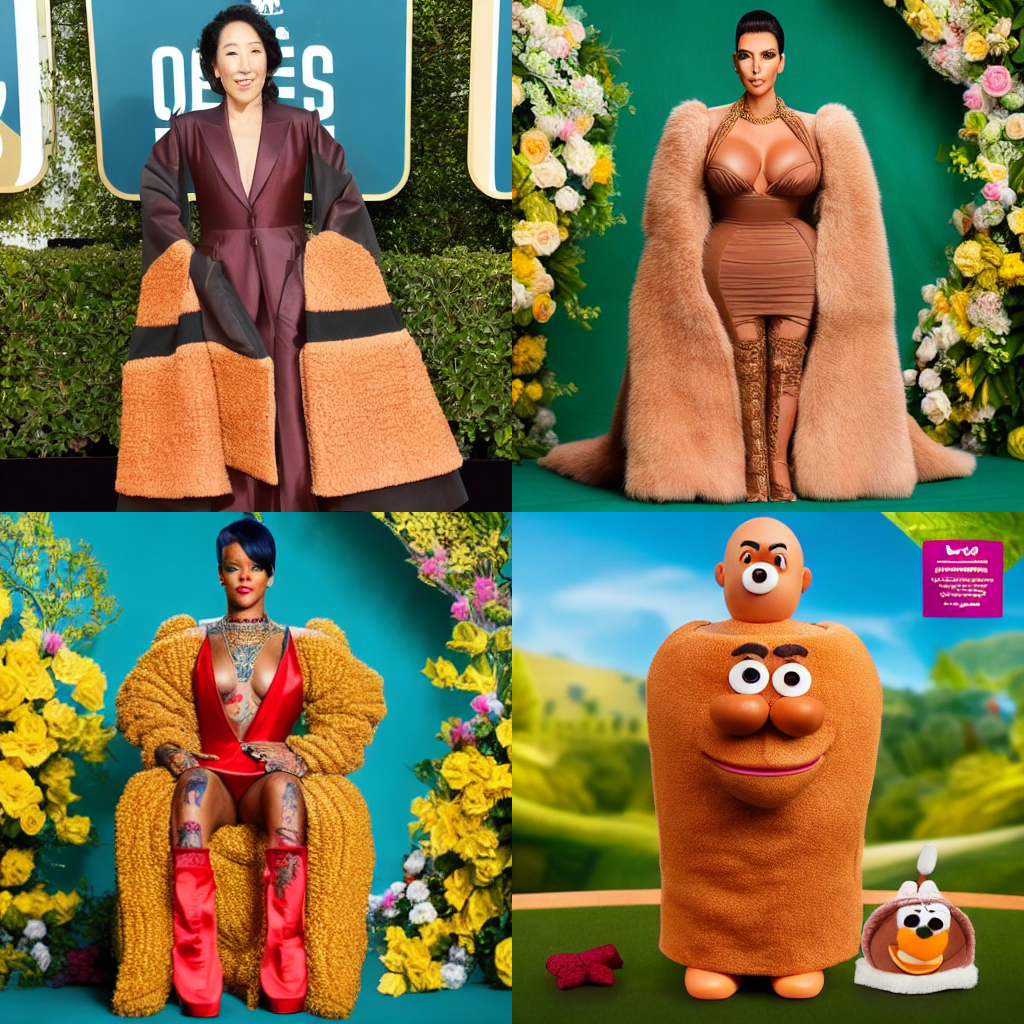

In [56]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

image_grid(output.images, 2, 2)